# Домашнее задание. Градиентный спуск

## Краткое напоминание
Рассматривается задача минимизации $f(x) \to \min\limits_{x \in \mathbb{R}^n}$
$$
x_{k+1} = x_k - \eta_k \nabla f(x_k)
$$

## Задача 1. Убираем шум с фотографии (denoising).
Будем рассматривать изображение, как скалярную функцию от двух переменных (координаты $x$ и $y$):
$$
f(x,y): \mathbb{R}^d \to \mathbb{R} \;\;\;\;\;\; (d = n \times n)
$$

Мы нарисуем енотика, который есть у всех. Вы можете загрузить Ваше любимое изображение с помощью функции [`imread`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.misc.imread.html). Люди, выполнившие задание полностью смогут принять участие в конкурсе самых мемных картинок по мнению преподавателя.

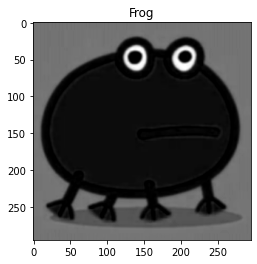

In [1]:
# Libraries
%matplotlib inline
from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Uploading and normalizing the image of raccoon
# original_image = (misc.face(gray = True)/255)[:, -768:]
original_image = mpimg.imread('frog.png')[:, :, 0]

# Plotting
plt.imshow(original_image, cmap='gray')
plt.title('Frog')
plt.show()

Пошумим? Добавим двухмерный гауссов шум с нулевым средним и задаваемой дисперсией
$$
y = enot(x,y) + \mathcal{N}(0, \sigma)
$$

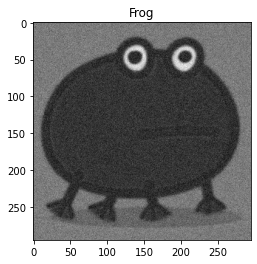

In [2]:
# Add some noise
sigma = 0.07
noisy_image = (original_image + sigma*np.random.randn(original_image.shape[0], original_image.shape[1]))

# Plotting
plt.imshow(noisy_image, cmap='gray')
# plt.axis('off')
plt.title('Frog')
plt.show()

Задача заключается в том, как, имея только шумное изображение $y$, получить максимально близкое к исходному (как минимум, менее шумное). Наша задача будет формулироваться следующим образом: 

$$
\min_{x \in R^d} f(x) = \frac{1}{2} \|y-x\|^2 + \lambda J(x),
$$

где $J(x)$ - некоторая функция, которая характеризует шумность (зернистость) картинки. То есть, решая задачу оптимизации мы должны получить с одной стороны изображение, близкое к $y$, с другой стороны, как можно менее шумное. Остается один важный вопрос - *что из себя представляет функция $J(x)$?*

### Подход бедных студентов
В каждой точке изображения можно посчитать производную по двум координтам. Таким образом, если изображение это функция $enot(x, y): \mathbb{R}^d \to \mathbb{R}$, то её градиент - это функция $\nabla enot(x,y): \mathbb{R}^d \to \mathbb{R}^2$, представляющая в каждой точке вектор из двух компонент $\left( \dfrac{\partial \;enot}{\partial x}, \dfrac{\partial \;enot}{\partial y} \right)$. Полный набор по все точкам - тензор размера $n \times n \times 2$

Величина градиента в каждой точке может быть оценена как

$$
g(x_i, y_i) = \sqrt{\left(\dfrac{\partial \;enot}{\partial x} (x_i, y_i)\right)^2 + \left(\dfrac{\partial \;enot}{\partial y} (x_i, y_i)\right)^2}
$$

Тогда будем строить $J(x)$ следующим образом:
$$
J(x) = \sum\limits_{x_i,y_i} \left[g(x_i, y_i)^2 \right]
$$

Тогда он будет характеризовать некоторую кумулятивную величину изменения значения пикселя по всему изображению. [Метод конечных разностей](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D1%8B%D1%85_%D1%80%D0%B0%D0%B7%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9) поможет оценить величину частной производной. Для решения проблемы с граничными значениями можно, например, считать, что изображение циклично продолжается по сторонам (т.е. следующие столбец/ строка после последнего - это первый).
$$
\nabla enot(x_i, y_i) = \left(enot(x_{i+1}, y_{i}) - enot(x_{i}, y_{i}), enot(x_{i}, y_{i+1}) - enot(x_{i}, y_{i})  \right)
$$

In [3]:
# Напишите функцию, которая принимает на вход черно-белое изображение nxn пикселей, а возвращает тензор размера nxnx2,
# содержащий частные производные в каждой точке, рассчитанный по методу конечных разностей.
def grad(image):
    return np.stack((np.roll(image, -1, axis=0) - image, np.roll(image, -1, axis=1) - image))

# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает матрицу размера nxn,
# содержащую величину градиента в квадрате в каждой точке.
def grad_magnitutde(image):
    grad_tensor = grad(image)
    return np.sqrt(grad_tensor[0] ** 2 + grad_tensor[1] ** 2)

# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает число J(x),
# подсчитанное по формуле выше.
def J(image):
    return np.sum(grad_magnitutde(image) ** 2)

# Напишите функцию, которая считает функцию потерь. (она возвращает число)
def f(image, noisy_image, lambd):
    return 0.5 * np.linalg.norm(image - noisy_image) ** 2 + lambd * J(image)

Для решения задачи методом градиентого спуска необходимо записать градиент целевой функции:
$$
\nabla f(x) = x-y + \lambda \nabla J(x)
$$
Вам предлагается самостоятельно предложить способ подсчета градиента функции $J(x)$. Заметим, что здесь есть широкий простор для творчества (начиная от аналитического вывода формулы и введения гессиана изображения, заканчивая, опять же, разностными схемами первого порядка). Поощрается Ваша интуиция и любое решение, подкрепленное убедительной мотивацией.

В явном виде выведенная формула даёт идеальную точность в сравнении например с разностными методами, а также не сильно дороже в вычислительном плане - делает где-то 5 n^2 операций

$J(x) = \sum\limits_{i, j} (x_{i+1, j} - x_{i, j})^2 + (x_{i, j+1} - x_{i, j})^2 = \sum\limits_{i, j} 4 x_{i, j}^2 - 2 x_{i, j} (x_{i + 1, j} + x_{i, j+ 1})$

$\frac{dJ}{x_{k, l}} = 8 x_{k, l} - 2(x_{k+1, l} + e_{k-1, l} + e_{k, l+1} + e_{k, l-1})$

$\nabla J(x) = 8 X - 2(X_{i+1, j} + X_{i-1, j} + X_{i, j+1} + X_{i, j-1})$ - получены циклическим сдвигом

In [4]:
# Напишите функцию, которая считает градиент функции J(x) (она возвращает массив nxn)
def dJ(image): 
    return 8 * image - 2 * (np.roll(image, -1, axis=0) + np.roll(image, 1, axis=0) + np.roll(image, -1, axis=1) + np.roll(image, 1, axis=1))

# Напишите функцию, которая считает градиент функции f(x) (она возвращает массив nxn)
def df(image, noisy_image, lambd):
    return image - noisy_image + lambd * dJ(image)

Тогда градиентный спуск здесь будет выглядеть следующим образом:
$$
x_{k+1} = x_k - \eta_k \nabla f(x_k), \;\;\;\;\; x_0 = y
$$

Попробуйте 2 стратегии выбора шага:
* постоянную (придется подбирать шаг экспериментально)
* $\eta_k = \dfrac{\eta_0 }{\sqrt{k}}$, $\eta_0$ подбирать

Критерий остановки: $\|\nabla f(x)\| \leq \varepsilon = 10^{-4}$

Напишите функцию, реализующую процедуру градиентного спуска и рисующую два графика $f(x_k), \nabla f(x_k)$

In [5]:
def poor_gradient_descent(noisy_image, eta, epsilon, labmd):
    step = 1
    x = noisy_image
    grad = df(x, noisy_image, labmd)
    
    f_array = np.array([])
    df_array = np.array([])
    
    
    while(np.linalg.norm(grad) > epsilon):
        f_array = np.append(f_array, f(x, noisy_image, labmd))
        df_array = np.append(df_array, np.linalg.norm(grad))
        x = x - eta(step) * grad
        grad = df(x, noisy_image, labmd)
        step += 1
    return x, f_array, df_array

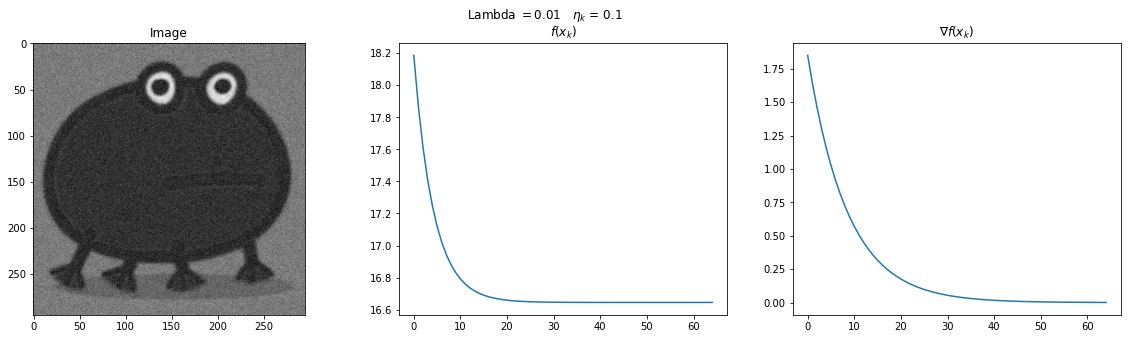

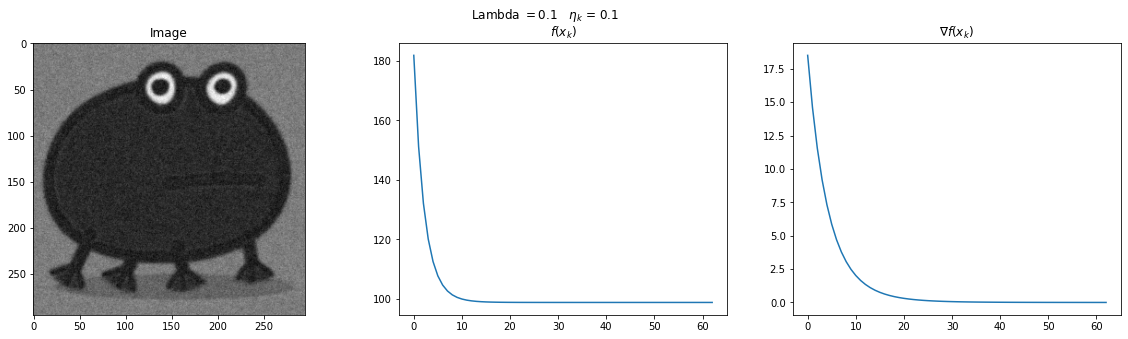

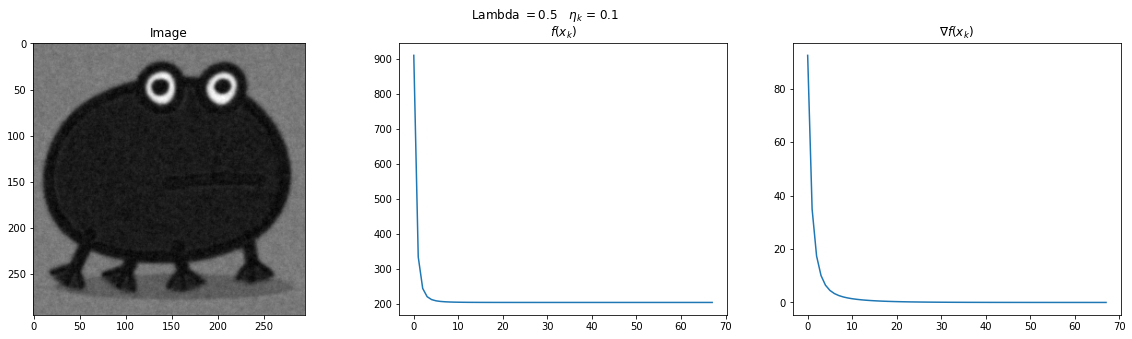

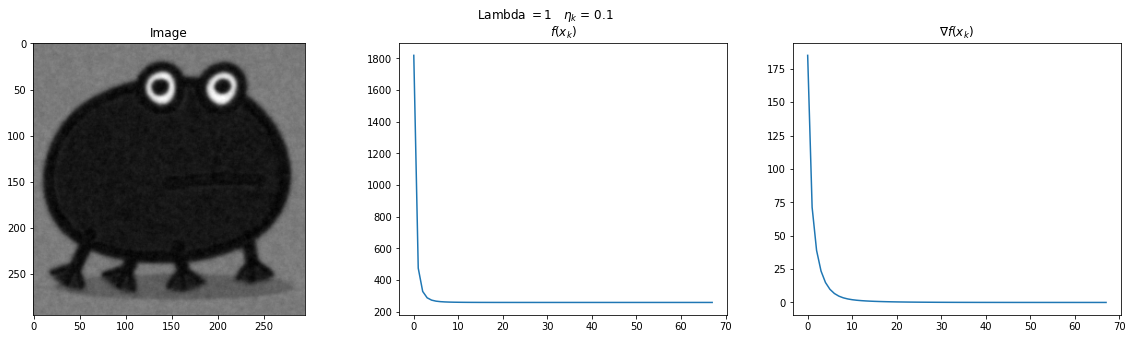

In [6]:
for labmd in [0.01, 0.1, 0.5, 1]:
    new_image, f_array, df_array = poor_gradient_descent(noisy_image, lambda k: 0.1, 0.001, labmd)
    fig, ax = plt.subplots(1, 3, figsize=(20,5))

    ax[0].set_title("Image")
    ax[0].imshow(new_image, cmap='gray')

    ax[1].set_title("$f(x_k)$")
    ax[1].plot(np.arange(0, f_array.size), f_array)

    ax[2].set_title("$\\nabla f(x_k)$")
    ax[2].plot(np.arange(0, df_array.size), df_array)

    fig.suptitle(f"Lambda $ = {labmd} \quad \\eta_k$ = {0.1}")
    plt.show()

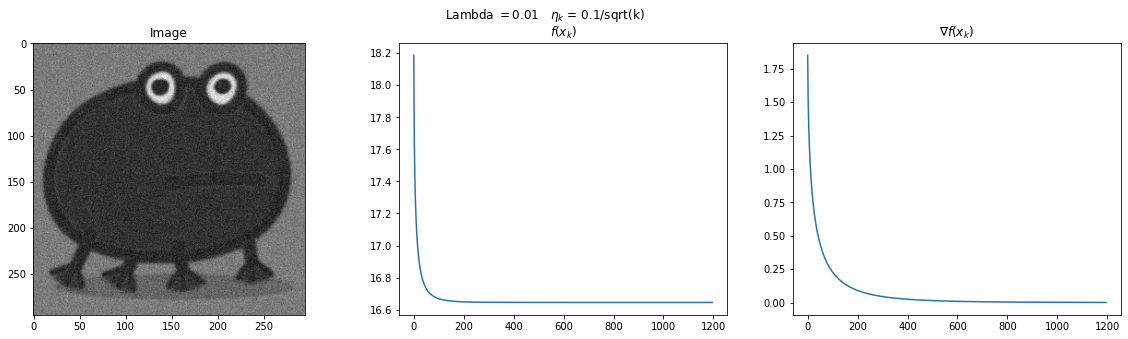

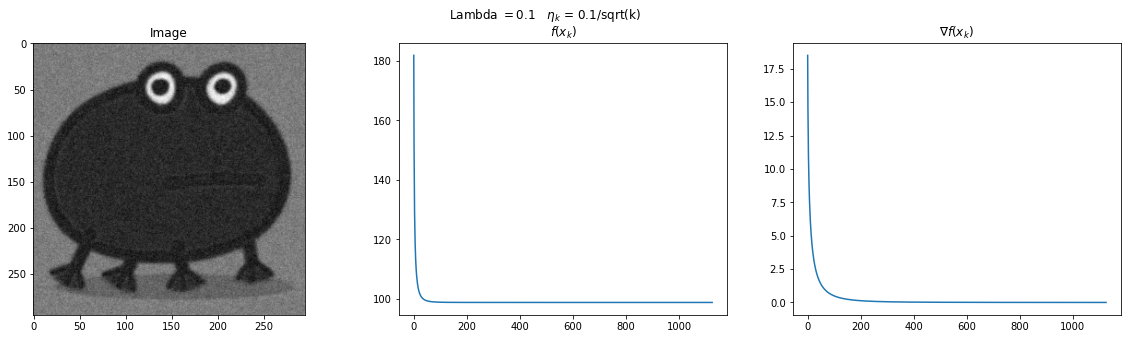

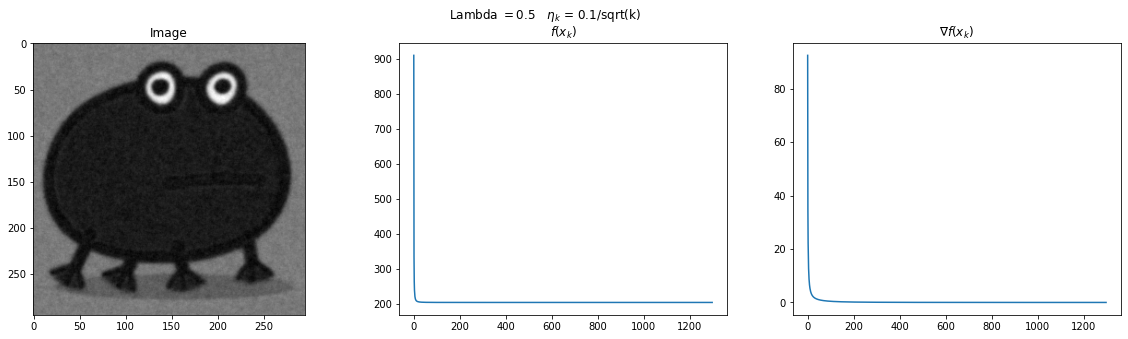

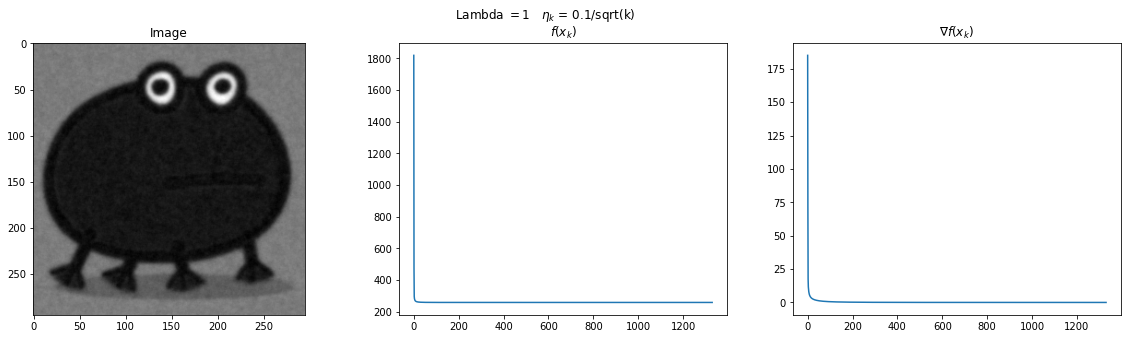

In [7]:
for labmd in [0.01, 0.1, 0.5, 1]:
    new_image, f_array, df_array = poor_gradient_descent(noisy_image, lambda k: 0.1 / np.sqrt(k), 0.001, labmd)
    fig, ax = plt.subplots(1, 3, figsize=(20,5))

    ax[0].set_title("Image")
    ax[0].imshow(new_image, cmap='gray')

    ax[1].set_title("$f(x_k)$")
    ax[1].plot(np.arange(0, f_array.size), f_array)

    ax[2].set_title("$\\nabla f(x_k)$")
    ax[2].plot(np.arange(0, df_array.size), df_array)

    fig.suptitle(f"Lambda $ = {labmd} \quad \\eta_k$ = {0.1}/sqrt(k)")
    plt.show()

### Подход богатых студентов (Total Variation Denoising)
[Здесь](http://www.numerical-tours.com/matlab/optim_1_gradient_descent/) можно почитать мануал на [тему](https://en.wikipedia.org/wiki/Total_variation_denoising). Реализуйте функции $J(x)$ и $\nabla J(x)$ в этом подходе согласно мануалу.

In [8]:
# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает число J(x),
# подсчитанное по формуле выше.

def J_tv(image):
    epsilon = 0.001
    dJ_dx = image - np.roll(image, 1, axis=0)
    dJ_dy = image - np.roll(image, 1, axis=1)
    return np.sum(np.sqrt(epsilon ** 2 + dJ_dx ** 2 + dJ_dy ** 2))


# Напишите функцию, которая считает функцию потерь. (она возвращает число)
def f_tv(image, noisy_image, lambd):
    return 0.5 * np.linalg.norm(image - noisy_image) ** 2 + lambd * J_tv(image)

# Напишите функцию, которая считает градиент функции J(x) (она возвращает массив nxn)
def dJ_tv(image):
    epsilon = 0.001
    dJ_dx = image - np.roll(image, 1, axis=0)
    dJ_dy = image - np.roll(image, 1, axis=1)
    magnitude = np.sqrt(epsilon ** 2 + dJ_dx ** 2 + dJ_dy ** 2)
    dJ_dx = dJ_dx / magnitude
    dJ_dy = dJ_dy / magnitude
    
    return -(np.roll(dJ_dx, -1, axis=0) - dJ_dx + np.roll(dJ_dy, -1, axis=1) - dJ_dy)

def df_tv(image, noisy_image, lambd):
    return image - noisy_image + lambd * dJ_tv(image)

Попробуйте 2 стратегии выбора шага:
* постоянную (придется подбирать шаг экспериментально)
* $\eta_k = \dfrac{\eta_0 }{\sqrt{k}}$, $\eta_0$ подбирать

Критерий остановки: $\|\nabla f(x)\| \leq \varepsilon = 10^{-4}$

Напишите функцию, реализующую процедуру градиентного спуска и рисующую два графика $f(x_k), \nabla f(x_k)$

In [9]:
def tv_gradient_descent(noisy_image, eta, epsilon, labmd):
    step = 1
    x = noisy_image
    grad = df_tv(x, noisy_image, labmd)
    
    f_array = np.array([])
    df_array = np.array([])
    
    
    while(np.linalg.norm(grad) > epsilon):
        f_array = np.append(f_array, f_tv(x, noisy_image, labmd))
        df_array = np.append(df_array, np.linalg.norm(grad))
        x = x - eta(step) * grad
        grad = df_tv(x, noisy_image, labmd)
        step += 1
    return x, f_array, df_array

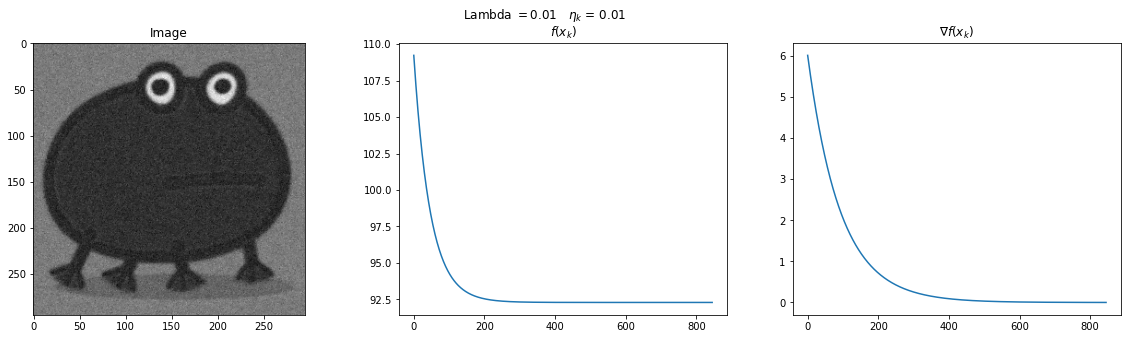

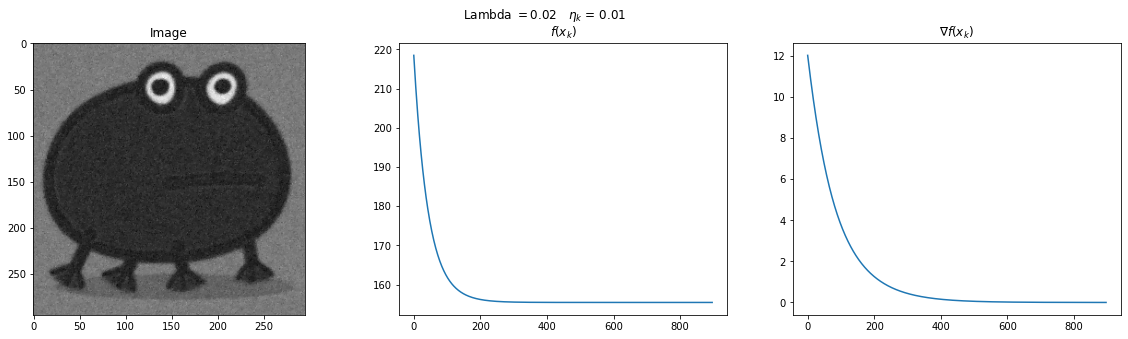

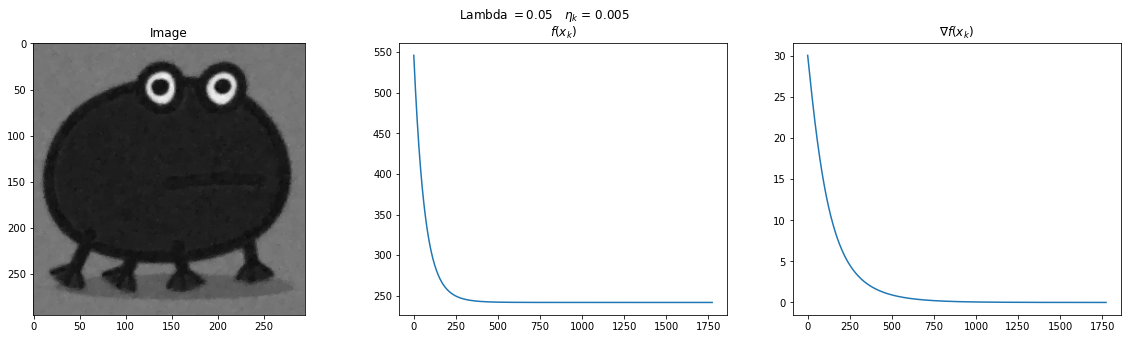

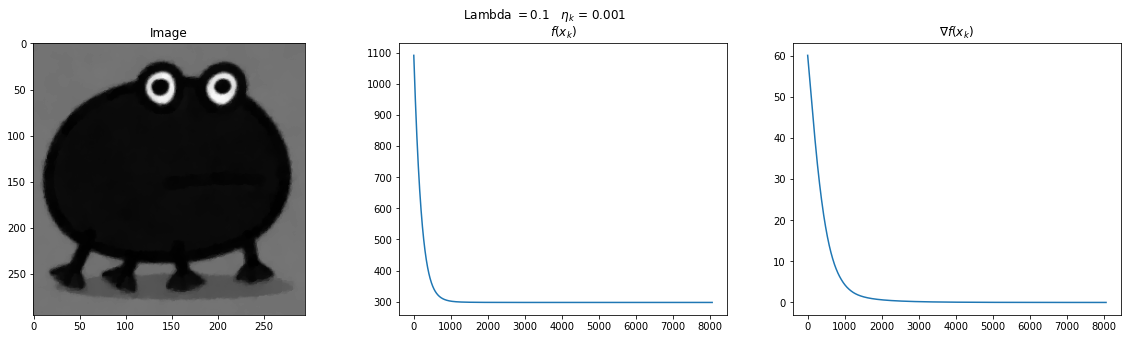

In [10]:
for labmd, eta in [[0.01, 0.01], [0.02, 0.01], [0.05, 0.005], [0.1, 0.001]]:
    new_image, f_array, df_array = tv_gradient_descent(noisy_image, lambda k: eta, 0.001, labmd)
    fig, ax = plt.subplots(1, 3, figsize=(20,5))

    ax[0].set_title("Image")
    ax[0].imshow(new_image, cmap='gray')

    ax[1].set_title("$f(x_k)$")
    ax[1].plot(np.arange(0, f_array.size), f_array)

    ax[2].set_title("$\\nabla f(x_k)$")
    ax[2].plot(np.arange(0, df_array.size), df_array)

    fig.suptitle(f"Lambda $ = {labmd} \quad \\eta_k$ = {eta}")
    plt.show()

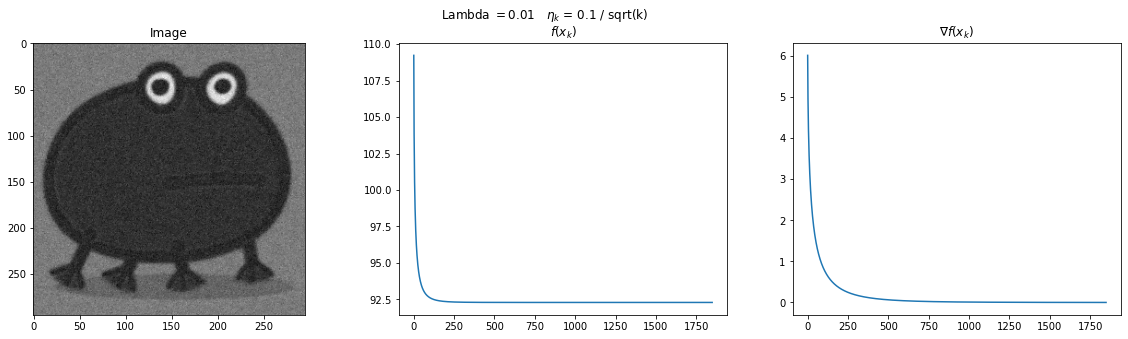

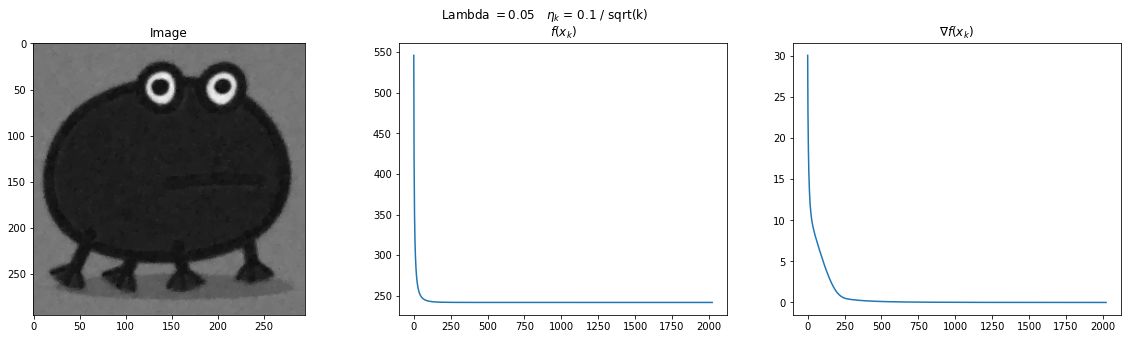

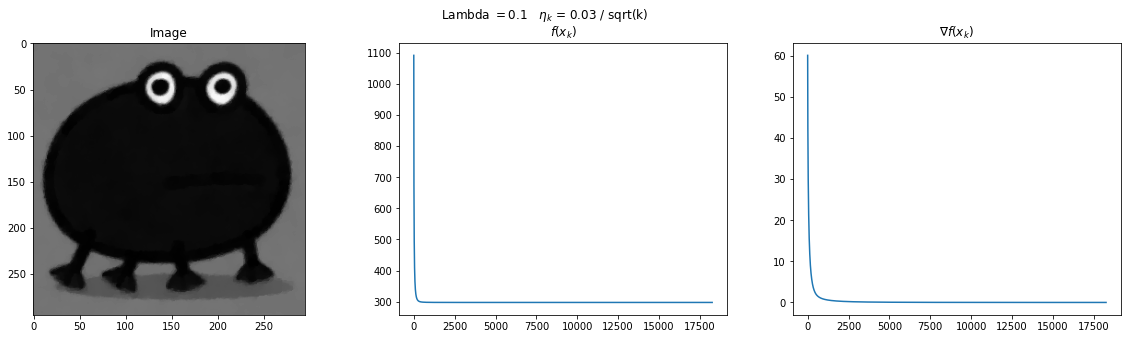

In [11]:
for labmd, eta in [[0.01, 0.1], [0.05, 0.1], [0.1, 0.03]]:
    new_image, f_array, df_array = tv_gradient_descent(noisy_image, lambda k: eta / np.sqrt(k), 0.001, labmd)
    fig, ax = plt.subplots(1, 3, figsize=(20,5))

    ax[0].set_title("Image")
    ax[0].imshow(new_image, cmap='gray')

    ax[1].set_title("$f(x_k)$")
    ax[1].plot(np.arange(0, f_array.size), f_array)

    ax[2].set_title("$\\nabla f(x_k)$")
    ax[2].plot(np.arange(0, df_array.size), df_array)

    fig.suptitle(f"Lambda $ = {labmd} \quad \\eta_k$ = {eta} / sqrt(k)")
    plt.show()